In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TensorFlow version: 2.10.0
GPU is available


In [2]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.applications import ResNet50
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import Image
from tensorflow.keras.utils import image_dataset_from_directory

In [3]:
img_height = 32
img_width = 32
batch_size = 500

# Load the training data
train_dataset = image_dataset_from_directory(
  "train",
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)

# Load the validation data
validation_dataset = image_dataset_from_directory(
  "validation",
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)

print("Training Classes:")
class_names = train_dataset.class_names
print(class_names)

print("Testing Classes:")
class_names = validation_dataset.class_names
print(class_names)

Found 80000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Training Classes:
['FAKE', 'REAL']
Testing Classes:
['FAKE', 'REAL']


In [4]:
val_true_classes = np.concatenate([y for x, y in validation_dataset], axis = 0)  # Get true labels
class_names = ['FAKE', 'REAL']
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True) 

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_tunned.h5',
    monitor='val_loss',               
    save_best_only=True,              
    save_weights_only=False,         
    mode='min'                        
)

## Using ResNet50 pretrained model

include_top=False: Removes the top (classification) layer of ResNet50, leaving only the convolutional layers. This allows the model to act as a feature extractor.

In [5]:
# Load the ResNet50 base model without the top layer and with ImageNet weights
ResNet_base_model = tf.keras.applications.ResNet50(
    include_top = False, 
    weights = 'imagenet', 
    input_shape = (img_height, img_width, 3),
    pooling = 'max'
)

# Set ResNet50 layers as trainable
ResNet_base_model.trainable = True

inputs = keras.Input(shape=(img_height, img_width, 3))

# Pass the input through the ResNet50 base model
x = ResNet_base_model(inputs, training=False)

# Add Batch Normalization
x = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)

x = layers.Dense(
    256,
    activation="relu",
    kernel_regularizer=regularizers.l2(0.01),
    activity_regularizer=regularizers.l1(0.01),
    bias_regularizer=regularizers.l1(0.01)
)(x)

x = layers.Dropout(rate=0.4, seed=512)(x)
x = layers.Dense(64, activation="relu")(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=keras.optimizers.Adamax(learning_rate=0.001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
)

# Display model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                             

In [6]:
print("Starting training with Transfer Learning using ResNet50...")
history = model.fit(
    train_dataset,
    validation_data = validation_dataset,
    epochs = 100,
    verbose = 1,
    callbacks=[early_stopping, checkpoint]
)
print("Transfer Learning training finished.")

Starting training with Transfer Learning using ResNet50...
Epoch 1/100
160/160 [==============================] - 71s 371ms/step - loss: 2.9904 - accuracy: 0.7383 - precision: 0.7606 - recall: 0.6955 - val_loss: 2.8186 - val_accuracy: 0.5914 - val_precision: 0.5503 - val_recall: 0.9999
Epoch 2/100
160/160 [==============================] - 63s 373ms/step - loss: 1.1382 - accuracy: 0.9210 - precision: 0.9234 - recall: 0.9183 - val_loss: 1.0054 - val_accuracy: 0.8744 - val_precision: 0.9811 - val_recall: 0.7635
Epoch 3/100
160/160 [==============================] - 63s 376ms/step - loss: 0.5830 - accuracy: 0.9323 - precision: 0.9343 - recall: 0.9299 - val_loss: 0.4737 - val_accuracy: 0.9377 - val_precision: 0.9437 - val_recall: 0.9309
Epoch 4/100
160/160 [==============================] - 67s 395ms/step - loss: 0.3534 - accuracy: 0.9398 - precision: 0.9407 - recall: 0.9388 - val_loss: 0.3514 - val_accuracy: 0.9194 - val_precision: 0.9790 - val_recall: 0.8572
Epoch 5/100
160/160 [========

### Accuracy on test dataset

In [7]:
test_dataset = image_dataset_from_directory(
  "test",
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)

# Evaluate the model on the test dataset
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(test_dataset)

# Print the metrics
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")
print(f"Val Precision: {val_precision:.4f}")
print(f"Val Recall: {val_recall:.4f}")

Found 20000 files belonging to 2 classes.
40/40 [==============================] - 11s 222ms/step - loss: 0.1612 - accuracy: 0.9542 - precision: 0.9614 - recall: 0.9465
Val Loss: 0.1612
Val Accuracy: 0.9542
Val Precision: 0.9614
Val Recall: 0.9465


In [8]:
def plot_loss_acc_training(history, epochs=30):
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  epochs = range(1, len(accuracy) + 1)

  plt.plot(epochs, accuracy, "bo", label="Training accuracy")
  plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
  plt.title("Training and validation accuracy")
  plt.legend()
  plt.figure()

  plt.plot(epochs, loss, "bo", label="Training loss")
  plt.plot(epochs, val_loss, "b", label="Validation loss")
  plt.title("Training and validation loss")
  plt.legend()
  plt.show()

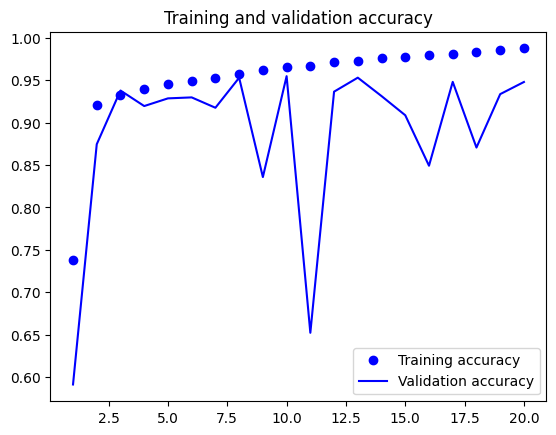

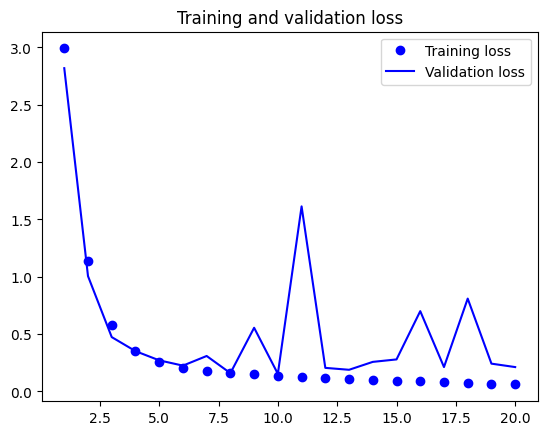

In [9]:
plot_loss_acc_training(history)